Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter

: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load Labeled DF

In [ ]:
main_df = pd.read_csv('/content/drive/MyDrive/AMIGOS/Exp2_DF_Labeled.csv')

In [ ]:
main_df

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,dominance,liking,familiarity,neutral,disgust,happiness,surprise,anger,fear,sadness
0,3,0,0.08,0.98,1,-0.385125,0.134773,-0.912970,-0.492953,0.132330,...,4.76,8.12,2.36,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,1,0.08,0.98,1,0.274001,0.025506,-0.961391,0.141810,0.033585,...,3.32,7.80,2.36,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,3,2,0.08,0.88,1,0.756852,0.231358,-0.611268,0.664592,0.245878,...,4.28,5.64,9.00,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,3,3,0.08,0.88,1,-0.143009,0.317884,-0.937282,-0.285699,0.318995,...,7.56,7.88,1.40,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6,0,0.20,0.98,1,-0.384993,0.134877,-0.913010,-0.492941,0.132440,...,4.76,8.12,2.36,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794837,21276,3,851.00,0.93,1,0.097215,-0.109715,-0.989198,-0.012894,-0.136827,...,5.88,7.80,1.96,0.0,0.0,1.0,0.0,0.0,0.0,1.0
794838,21279,0,851.12,0.98,1,0.493929,0.020739,-0.869255,0.376686,0.027592,...,3.24,8.12,1.32,0.0,0.0,1.0,0.0,0.0,0.0,1.0
794839,21279,1,851.12,0.98,1,-0.068890,-0.041851,-0.996746,-0.217434,-0.026081,...,6.36,6.04,6.36,1.0,0.0,1.0,0.0,0.0,0.0,1.0
794840,21279,2,851.12,0.98,1,-0.301181,0.036381,-0.952873,-0.429786,0.021777,...,2.60,8.36,2.28,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# **Models**

Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
import pickle
from keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall

Thresholding all the labels

In [ ]:
# Thresholding the 'arousal' column
main_df['arousal_bin'] = (main_df['arousal'] >= 4.5).astype(int)
Counter(main_df['arousal_bin'])

Counter({1: 606169, 0: 188673})

In [ ]:
# Thresholding the 'valence' column
main_df['valence_bin'] = (main_df['valence'] >= 4.5).astype(int)
Counter(main_df['valence_bin'])

Counter({1: 494792, 0: 300050})

In [ ]:
# Thresholding the 'dominance' column
main_df['dominance_bin'] = (main_df['dominance'] >= 4.5).astype(int)
Counter(main_df['dominance_bin'])

Counter({1: 356726, 0: 438116})

In [ ]:
# Thresholding the 'liking' column
main_df['liking_bin'] = (main_df['liking'] >= 4.5).astype(int)
Counter(main_df['liking_bin'])

Counter({1: 652215, 0: 142627})

Re-Arranging the columns

In [ ]:
main_df.iloc[:, 5:-17]

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,-0.385125,0.134773,-0.912970,-0.492953,0.132330,-0.859934,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.274001,0.025506,-0.961391,0.141810,0.033585,-0.989324,0.210,0.030,434.0,435.2,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.756852,0.231358,-0.611268,0.664592,0.245878,-0.705593,0.824,0.348,156.8,158.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.143009,0.317884,-0.937282,-0.285699,0.318995,-0.903669,-0.229,0.333,753.6,754.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.384993,0.134877,-0.913010,-0.492941,0.132440,-0.859923,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794837,0.097215,-0.109715,-0.989198,-0.012894,-0.136827,-0.990511,0.043,-0.124,447.8,449.7,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
794838,0.493929,0.020739,-0.869255,0.376686,0.027592,-0.925930,0.452,0.027,121.7,122.9,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
794839,-0.068890,-0.041851,-0.996746,-0.217434,-0.026081,-0.975727,-0.144,-0.034,723.3,724.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
794840,-0.301181,0.036381,-0.952873,-0.429786,0.021777,-0.902668,-0.375,0.031,1062.9,1064.2,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


Features

In [ ]:
# Features (all columns except the last 13)
X = main_df.iloc[:, 5:-17].values

In [ ]:
X

array([[-0.385125,  0.134773, -0.91297 , ...,  1.      ,  1.      ,
         0.      ],
       [ 0.274001,  0.025506, -0.961391, ...,  1.      ,  1.      ,
         1.      ],
       [ 0.756852,  0.231358, -0.611268, ...,  1.      ,  1.      ,
         0.      ],
       ...,
       [-0.06889 , -0.041851, -0.996746, ...,  0.      ,  0.      ,
         1.      ],
       [-0.301181,  0.036381, -0.952873, ...,  0.      ,  1.      ,
         1.      ],
       [ 0.092577, -0.119303, -0.988532, ...,  0.      ,  0.      ,
         1.      ]])

Normalizing the Features

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

array([[-1.46275723,  0.19533889,  0.11783669, ...,  2.45966901,
         0.99654616, -1.02236255],
       [ 0.65787908, -0.47129481, -0.48537572, ...,  2.45966901,
         0.99654616,  0.97812659],
       [ 2.21137774,  0.7846002 ,  3.87633796, ...,  2.45966901,
         0.99654616, -1.02236255],
       ...,
       [-0.44531986, -0.88223723, -0.92581633, ..., -0.40655877,
        -1.00346581,  0.97812659],
       [-1.19268035, -0.40494686, -0.37926136, ..., -0.40655877,
         0.99654616,  0.97812659],
       [ 0.07417532, -1.35476886, -0.8234891 , ..., -0.40655877,
        -1.00346581,  0.97812659]])

In [ ]:
len(X_scaled[0])

709

Applying PCA

In [ ]:
# Apply PCA
pca = PCA(n_components=0.999)  # Retain 99.9% variance
X_pca = pca.fit_transform(X_scaled)

In [ ]:
len(X_pca[10])

71

In [ ]:
# Check explained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance retained: {explained_variance * 100:.2f}%")

Explained variance retained: 99.90%


In [ ]:
# Output the reduced dataset
print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_pca.shape}")

Original shape: (794842, 709)
Reduced shape: (794842, 71)


## **ANN Individual Models**

### **Label: Arousal**

In [ ]:
print(main_df['arousal_bin'])

0         1
1         1
2         1
3         1
4         1
         ..
794837    1
794838    1
794839    0
794840    0
794841    1
Name: arousal_bin, Length: 794842, dtype: int64


In [ ]:
# Labels (binary column 'arousal_bin')
y = main_df['arousal_bin'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 11.9300839 , -17.60886481,  13.56151083, ...,  -0.81886102,
         -0.13994202,  -0.1819577 ],
       [  7.26696586,  10.18823174,  -0.45652345, ...,   0.03468289,
         -0.07370913,  -0.13982535],
       [  7.26307734,  12.36100519,   5.2381857 , ...,   0.20595778,
         -0.2392185 ,   0.12590584],
       ...,
       [ 10.96842159, -15.63031544,   9.64572114, ...,  -0.18606772,
          0.83156792,  -0.95443905],
       [ 11.77145124, -17.75633284,   9.06669213, ...,  -0.09804896,
         -0.20568523,  -0.17608556],
       [  9.56154698,  -5.15735908,   0.6546081 , ...,  -0.08903095,
         -0.1667219 ,   0.07427969]])

In [ ]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
Counter(y_train)

Counter({1: 484872, 0: 151001})

In [ ]:
Counter(y_test)

Counter({0: 37672, 1: 121297})

In [ ]:
X_train.shape

(635873, 71)

In [ ]:
X_test.shape

(158969, 71)

In [ ]:
# Define the model
model = Sequential([
    # Layer 1
    Dense(1024, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 2
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 3
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 4
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 5
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 6
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 7
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 8
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 9
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output Layer 10
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Adaptive learning rate optimizer
              loss='binary_crossentropy',  # Suitable for binary classification
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop training if no improvement in 3 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=2,  # Trigger after 2 epochs of no improvement
    min_lr=1e-6  # Set a lower bound for the learning rate
)

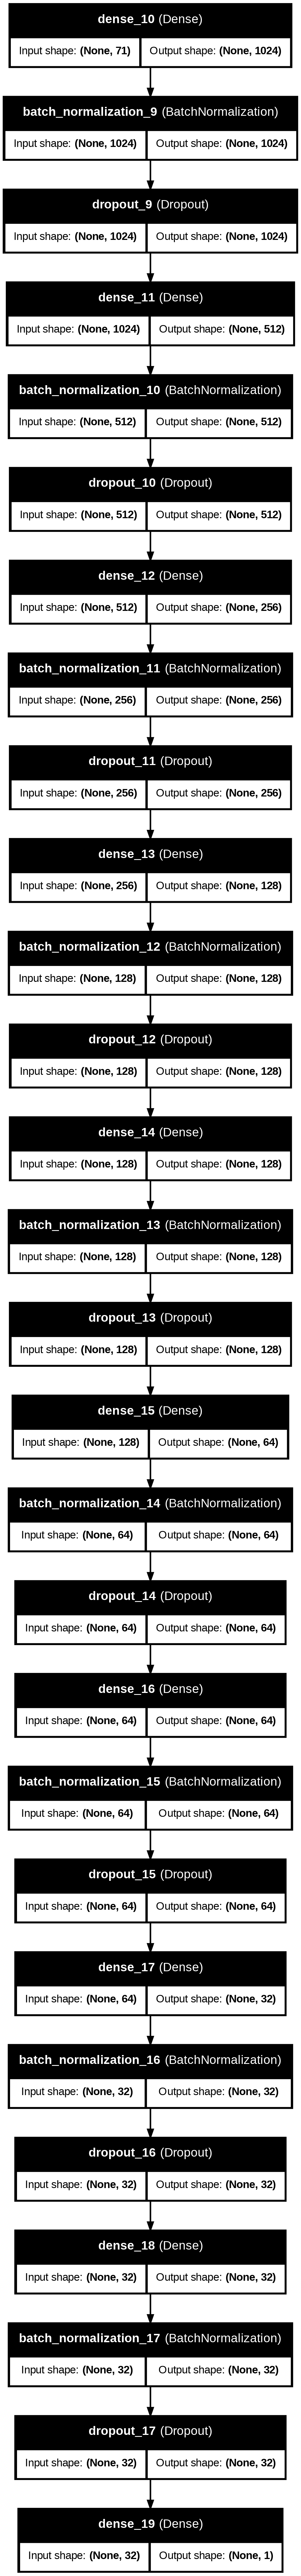

In [ ]:
# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model with mini-batches
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),  # Use a validation set for monitoring
    epochs=20,  # Set a high epoch count to leverage early stopping
    batch_size=64,  # Use mini-batches for efficient training
    callbacks=[early_stopping, reduce_lr],  # Apply callbacks
    verbose=1  # Show training progress
)

Epoch 1/20
9936/9936 [==============================] - 235s 23ms/step - loss: 0.1731 - accuracy: 0.9306 - val_loss: 0.0741 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 2/20
9936/9936 [==============================] - 225s 23ms/step - loss: 0.0870 - accuracy: 0.9670 - val_loss: 0.0525 - val_accuracy: 0.9785 - lr: 0.0010
Epoch 3/20
9936/9936 [==============================] - 224s 23ms/step - loss: 0.0701 - accuracy: 0.9738 - val_loss: 0.0416 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 4/20
9936/9936 [==============================] - 224s 23ms/step - loss: 0.0613 - accuracy: 0.9773 - val_loss: 0.0418 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 5/20
9936/9936 [==============================] - 224s 23ms/step - loss: 0.0566 - accuracy: 0.9791 - val_loss: 0.0359 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 6/20
9936/9936 [==============================] - 224s 23ms/step - loss: 0.0524 - accuracy: 0.9808 - val_loss: 0.0322 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 7/20
9936/9936 [==================

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 99.36%


In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

4968/4968 [==============================] - 11s 2ms/step


In [ ]:
y_pred

array([[7.4942941e-06],
       [9.9999267e-01],
       [9.9997604e-01],
       ...,
       [9.9995500e-01],
       [2.2340337e-04],
       [9.9997878e-01]], dtype=float32)

In [ ]:
y_pred_classes

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

4968/4968 [==============================] - 12s 2ms/step


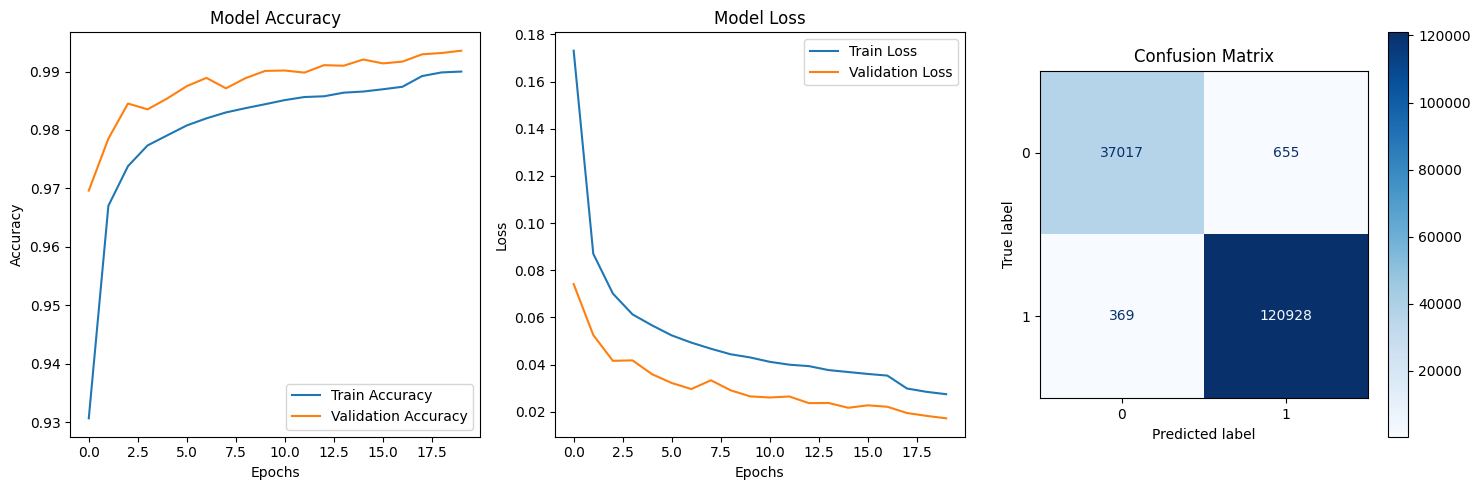

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create subplots: 1 row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training & validation loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax[2], cmap="Blues")
ax[2].set_title('Confusion Matrix')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Save / Load Model

In [ ]:
import pickle

# Save the model using pickle
with open('/content/drive/MyDrive/AMIGOS/arousal_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# # Load the model from the .pkl file
# with open('/content/drive/MyDrive/AMIGOS/arousal_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Check the model summary to verify
# loaded_model.summary()

### **Label: Valence**

In [ ]:
print(main_df['valence_bin'])

0         1
1         1
2         0
3         0
4         1
         ..
794837    1
794838    1
794839    0
794840    1
794841    1
Name: valence_bin, Length: 794842, dtype: int64


In [ ]:
# Labels (binary column 'valence_bin')
y = main_df['valence_bin'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 11.9300839 , -17.60886481,  13.56151083, ...,  -0.81886102,
         -0.13994202,  -0.1819577 ],
       [  7.26696586,  10.18823174,  -0.45652345, ...,   0.03468289,
         -0.07370913,  -0.13982535],
       [  7.26307734,  12.36100519,   5.2381857 , ...,   0.20595778,
         -0.2392185 ,   0.12590584],
       ...,
       [ 10.96842159, -15.63031544,   9.64572114, ...,  -0.18606772,
          0.83156792,  -0.95443905],
       [ 11.77145124, -17.75633284,   9.06669213, ...,  -0.09804896,
         -0.20568523,  -0.17608556],
       [  9.56154698,  -5.15735908,   0.6546081 , ...,  -0.08903095,
         -0.1667219 ,   0.07427969]])

In [ ]:
y_train

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
Counter(y_train)

Counter({1: 396174, 0: 239699})

In [ ]:
Counter(y_test)

Counter({0: 60351, 1: 98618})

In [ ]:
X_train.shape

(635873, 71)

In [ ]:
X_test.shape

(158969, 71)

In [ ]:
# Define the model
model = Sequential([
    # Layer 1
    Dense(1024, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 2
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 3
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 4
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 5
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 6
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 7
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 8
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 9
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output Layer 10
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1),  # Adaptive learning rate optimizer
              loss='binary_crossentropy',  # Suitable for binary classification
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop training if no improvement in 3 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=2,  # Trigger after 2 epochs of no improvement
    min_lr=1e-6  # Set a lower bound for the learning rate
)

In [ ]:
# Train the model with mini-batches
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),  # Use a validation set for monitoring
    epochs=15,  # Set a high epoch count to leverage early stopping
    batch_size=64,  # Use mini-batches for efficient training
    callbacks=[early_stopping, reduce_lr],  # Apply callbacks
    verbose=1  # Show training progress
)

Epoch 1/15
9936/9936 [==============================] - 66s 6ms/step - loss: 0.2525 - accuracy: 0.8983 - val_loss: 0.1105 - val_accuracy: 0.9583 - lr: 0.1000
Epoch 2/15
9936/9936 [==============================] - 62s 6ms/step - loss: 0.1550 - accuracy: 0.9435 - val_loss: 0.0741 - val_accuracy: 0.9720 - lr: 0.1000
Epoch 3/15
9936/9936 [==============================] - 62s 6ms/step - loss: 0.1291 - accuracy: 0.9540 - val_loss: 0.0633 - val_accuracy: 0.9759 - lr: 0.1000
Epoch 4/15
9936/9936 [==============================] - 62s 6ms/step - loss: 0.1153 - accuracy: 0.9594 - val_loss: 0.0590 - val_accuracy: 0.9769 - lr: 0.1000
Epoch 5/15
9936/9936 [==============================] - 62s 6ms/step - loss: 0.1060 - accuracy: 0.9625 - val_loss: 0.0523 - val_accuracy: 0.9803 - lr: 0.1000
Epoch 6/15
9936/9936 [==============================] - 63s 6ms/step - loss: 0.0987 - accuracy: 0.9657 - val_loss: 0.0472 - val_accuracy: 0.9822 - lr: 0.1000
Epoch 7/15
9936/9936 [==============================

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 98.45%


4968/4968 [==============================] - 8s 2ms/step


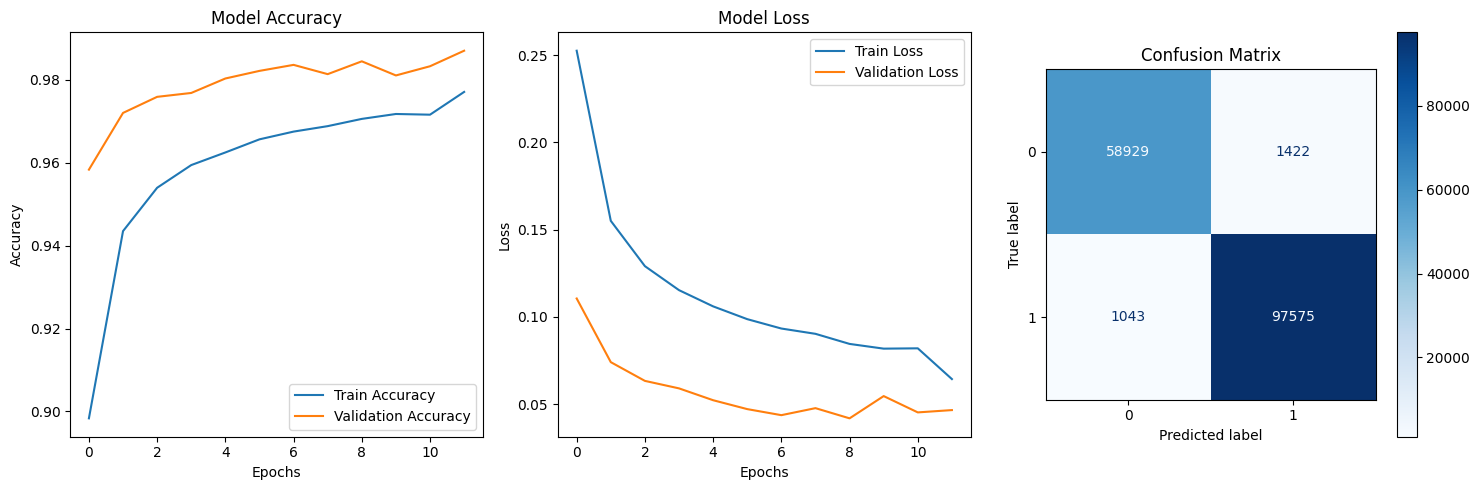

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create subplots: 1 row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training & validation loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax[2], cmap="Blues")
ax[2].set_title('Confusion Matrix')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Save / Load Model

In [ ]:
import pickle

# Save the model using pickle
with open('/content/drive/MyDrive/AMIGOS/valence_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# # Load the model from the .pkl file
# with open('/content/drive/MyDrive/AMIGOS/valence_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Check the model summary to verify
# loaded_model.summary()

### **Label: Dominance**

In [ ]:
print(main_df['dominance_bin'])

0         1
1         0
2         0
3         1
4         1
         ..
794837    1
794838    0
794839    1
794840    0
794841    1
Name: dominance_bin, Length: 794842, dtype: int64


In [ ]:
# Labels (binary column 'dominance_bin')
y = main_df['dominance_bin'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 11.9300839 , -17.60886481,  13.56151083, ...,  -0.81886102,
         -0.13994202,  -0.1819577 ],
       [  7.26696586,  10.18823174,  -0.45652345, ...,   0.03468289,
         -0.07370913,  -0.13982535],
       [  7.26307734,  12.36100519,   5.2381857 , ...,   0.20595778,
         -0.2392185 ,   0.12590584],
       ...,
       [ 10.96842159, -15.63031544,   9.64572114, ...,  -0.18606772,
          0.83156792,  -0.95443905],
       [ 11.77145124, -17.75633284,   9.06669213, ...,  -0.09804896,
         -0.20568523,  -0.17608556],
       [  9.56154698,  -5.15735908,   0.6546081 , ...,  -0.08903095,
         -0.1667219 ,   0.07427969]])

In [ ]:
y_train

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
Counter(y_train)

Counter({0: 350239, 1: 285634})

In [ ]:
Counter(y_test)

Counter({1: 71092, 0: 87877})

In [ ]:
X_train.shape

(635873, 71)

In [ ]:
X_test.shape

(158969, 71)

In [ ]:
# Define the model
model = Sequential([
    # Layer 1
    Dense(1024, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 2
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 3
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 4
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 5
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 6
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 7
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 8
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 9
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output Layer 10
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.5),  # Adaptive learning rate optimizer
              loss='binary_crossentropy',  # Suitable for binary classification
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop training if no improvement in 3 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=2,  # Trigger after 2 epochs of no improvement
    min_lr=1e-6  # Set a lower bound for the learning rate
)

In [ ]:
# Train the model with mini-batches
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),  # Use a validation set for monitoring
    epochs=15,  # Set a high epoch count to leverage early stopping
    batch_size=64,  # Use mini-batches for efficient training
    callbacks=[early_stopping, reduce_lr],  # Apply callbacks
    verbose=1  # Show training progress
)

Epoch 1/15
9936/9936 [==============================] - 67s 6ms/step - loss: 0.4120 - accuracy: 0.8833 - val_loss: 0.1366 - val_accuracy: 0.9429 - lr: 0.5000
Epoch 2/15
9936/9936 [==============================] - 62s 6ms/step - loss: 0.3571 - accuracy: 0.9249 - val_loss: 0.7899 - val_accuracy: 0.9443 - lr: 0.5000
Epoch 3/15
9936/9936 [==============================] - 65s 7ms/step - loss: 0.3057 - accuracy: 0.9377 - val_loss: 1.4825 - val_accuracy: 0.9658 - lr: 0.5000
Epoch 4/15
9936/9936 [==============================] - 63s 6ms/step - loss: 0.1291 - accuracy: 0.9596 - val_loss: 0.0538 - val_accuracy: 0.9790 - lr: 0.2500
Epoch 5/15
9936/9936 [==============================] - 63s 6ms/step - loss: 0.1175 - accuracy: 0.9639 - val_loss: 0.0992 - val_accuracy: 0.9634 - lr: 0.2500
Epoch 6/15
9936/9936 [==============================] - 63s 6ms/step - loss: 0.1070 - accuracy: 0.9670 - val_loss: 4.5308 - val_accuracy: 0.9832 - lr: 0.2500
Epoch 7/15
9936/9936 [==============================

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 99.00%


4968/4968 [==============================] - 8s 2ms/step


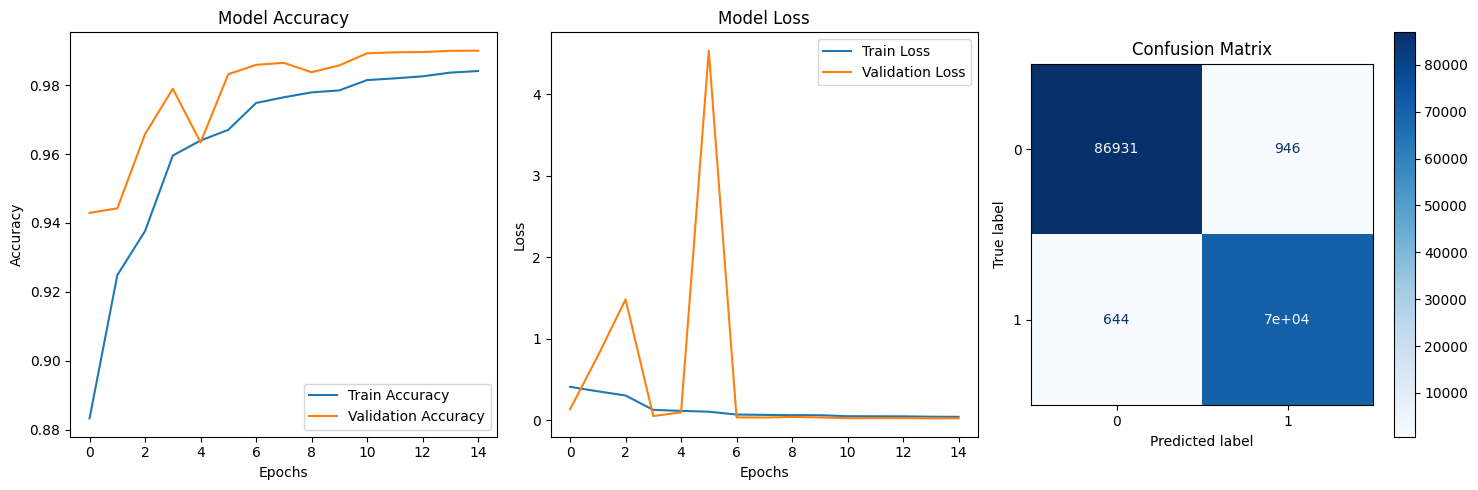

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create subplots: 1 row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training & validation loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax[2], cmap="Blues")
ax[2].set_title('Confusion Matrix')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Save / Load Model

In [ ]:
import pickle

# Save the model using pickle
with open('/content/drive/MyDrive/AMIGOS/dominance_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# # Load the model from the .pkl file
# with open('/content/drive/MyDrive/AMIGOS/dominance_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Check the model summary to verify
# loaded_model.summary()

### **Label: Liking**

In [ ]:
print(main_df['liking_bin'])

0         1
1         1
2         1
3         1
4         1
         ..
794837    1
794838    1
794839    1
794840    1
794841    1
Name: liking_bin, Length: 794842, dtype: int64


In [ ]:
# Labels (binary column 'liking_bin')
y = main_df['liking_bin'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 11.9300839 , -17.60886481,  13.56151083, ...,  -0.81886102,
         -0.13994202,  -0.1819577 ],
       [  7.26696586,  10.18823174,  -0.45652345, ...,   0.03468289,
         -0.07370913,  -0.13982535],
       [  7.26307734,  12.36100519,   5.2381857 , ...,   0.20595778,
         -0.2392185 ,   0.12590584],
       ...,
       [ 10.96842159, -15.63031544,   9.64572114, ...,  -0.18606772,
          0.83156792,  -0.95443905],
       [ 11.77145124, -17.75633284,   9.06669213, ...,  -0.09804896,
         -0.20568523,  -0.17608556],
       [  9.56154698,  -5.15735908,   0.6546081 , ...,  -0.08903095,
         -0.1667219 ,   0.07427969]])

In [ ]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
Counter(y_train)

Counter({1: 522033, 0: 113840})

In [ ]:
Counter(y_test)

Counter({1: 130182, 0: 28787})

In [ ]:
X_train.shape

(635873, 71)

In [ ]:
X_test.shape

(158969, 71)

In [ ]:
# Define the model
model = Sequential([
    # Layer 1
    Dense(1024, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 2
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 3
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 4
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 5
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 6
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 7
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 8
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 9
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output Layer 10
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.5),  # Adaptive learning rate optimizer
              loss='binary_crossentropy',  # Suitable for binary classification
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop training if no improvement in 3 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=2,  # Trigger after 2 epochs of no improvement
    min_lr=1e-6  # Set a lower bound for the learning rate
)

In [ ]:
# Train the model with mini-batches
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),  # Use a validation set for monitoring
    epochs=15,  # Set a high epoch count to leverage early stopping
    batch_size=64,  # Use mini-batches for efficient training
    callbacks=[early_stopping, reduce_lr],  # Apply callbacks
    verbose=1  # Show training progress
)

Epoch 1/15
9936/9936 [==============================] - 67s 6ms/step - loss: 0.4680 - accuracy: 0.8891 - val_loss: 740.2043 - val_accuracy: 0.9343 - lr: 0.5000
Epoch 2/15
9936/9936 [==============================] - 63s 6ms/step - loss: 0.4225 - accuracy: 0.9390 - val_loss: 0.0733 - val_accuracy: 0.9818 - lr: 0.5000
Epoch 3/15
9936/9936 [==============================] - 65s 7ms/step - loss: 0.3780 - accuracy: 0.9518 - val_loss: 1.3351 - val_accuracy: 0.9858 - lr: 0.5000
Epoch 4/15
9936/9936 [==============================] - 63s 6ms/step - loss: 0.3634 - accuracy: 0.9585 - val_loss: 0.4242 - val_accuracy: 0.9867 - lr: 0.5000
Epoch 5/15
9936/9936 [==============================] - 66s 7ms/step - loss: 0.1079 - accuracy: 0.9740 - val_loss: 0.0509 - val_accuracy: 0.9793 - lr: 0.2500
Epoch 6/15
9936/9936 [==============================] - 64s 6ms/step - loss: 0.1104 - accuracy: 0.9773 - val_loss: 0.0309 - val_accuracy: 0.9901 - lr: 0.2500
Epoch 7/15
9936/9936 [============================

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 99.39%


4968/4968 [==============================] - 8s 2ms/step


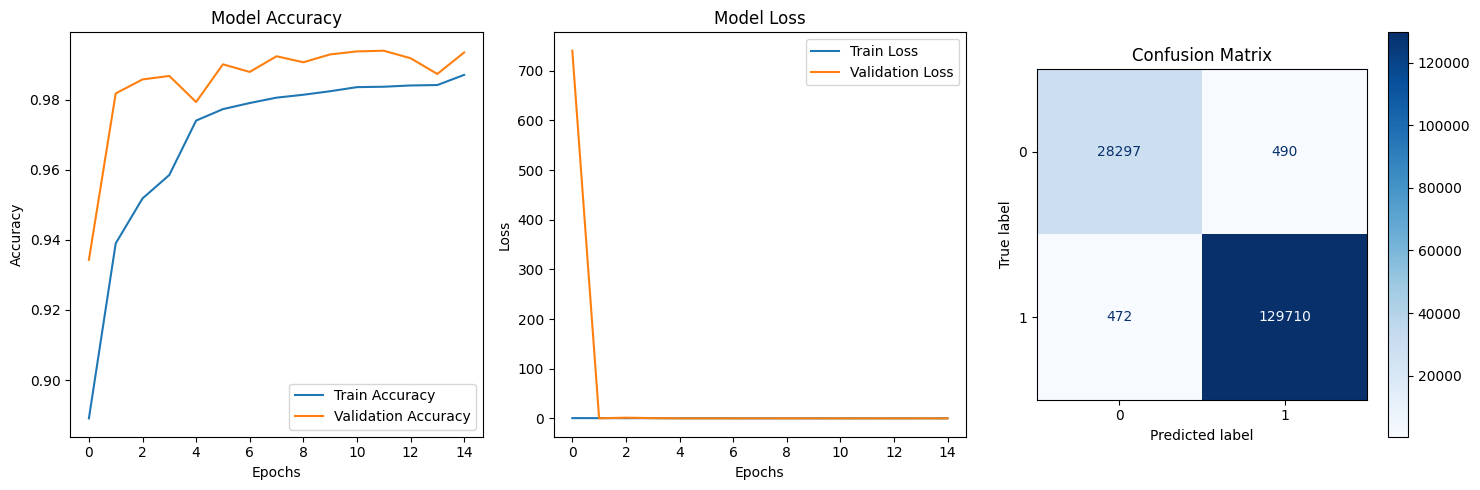

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create subplots: 1 row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training & validation loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax[2], cmap="Blues")
ax[2].set_title('Confusion Matrix')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Save / Load Model

In [ ]:
import pickle

# Save the model using pickle
with open('/content/drive/MyDrive/AMIGOS/liking_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# # Load the model from the .pkl file
# with open('/content/drive/MyDrive/AMIGOS/liking_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Check the model summary to verify
# loaded_model.summary()

## **ANN Small Indv Models**

### **Label: Valence**

In [ ]:
print(main_df['valence'])

0         6.36
1         5.00
2         4.20
3         3.64
4         6.36
          ... 
475173    9.16
475174    7.48
475175    9.16
475176    7.48
475177    9.16
Name: valence, Length: 475178, dtype: float64


In [ ]:
# Thresholding the 'arousal' column
main_df['valence_bin'] = (main_df['valence'] >= 4.5).astype(int)

In [ ]:
Counter(main_df['valence_bin'])

Counter({1: 290350, 0: 184828})

In [ ]:
main_df.iloc[:, 5:-15].head()

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,-0.385125,0.134773,-0.912970,-0.492953,0.132330,-0.859934,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.274001,0.025506,-0.961391,0.141810,0.033585,-0.989324,0.210,0.030,434.0,435.2,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.756852,0.231358,-0.611268,0.664592,0.245878,-0.705593,0.824,0.348,156.8,158.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.143009,0.317884,-0.937282,-0.285699,0.318995,-0.903669,-0.229,0.333,753.6,754.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.384993,0.134877,-0.913010,-0.492941,0.132440,-0.859923,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475173,-0.110487,0.521078,-0.846328,-0.257413,0.516145,-0.816905,-0.218,0.558,723.6,724.6,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
475174,-0.433888,0.591868,-0.679289,-0.562977,0.533961,-0.630827,-0.650,0.710,979.7,981.3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
475175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,721.9,722.9,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
475176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,980.3,981.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
# Features (all columns except the last 13)
X = main_df.iloc[:, 5:-15].values

In [ ]:
# Labels (binary column 'arousal_bin')
y = main_df['valence_bin'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 0.401387,  0.339054, -0.850841, ...,  0.      ,  1.      ,
         0.      ],
       [ 0.507299,  0.117087, -0.853779, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.450131, -0.034265, -0.892305, ...,  0.      ,  1.      ,
         1.      ],
       ...,
       [ 0.740757,  0.187753, -0.645002, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.427458,  0.095352, -0.898993, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.278451,  0.043809, -0.959451, ...,  0.      ,  0.      ,
         0.      ]])

In [ ]:
y_train

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
Counter(y_train)

Counter({0: 147808, 1: 232334})

In [ ]:
# Normalize features for better training (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train

array([[ 1.12430756,  0.96054097,  0.78635026, ..., -0.42433416,
         0.98320006, -0.93910049],
       [ 1.48183003, -0.29584174,  0.75027026, ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 1.28885053, -1.15252781,  0.2771531 , ..., -0.42433416,
         0.98320006,  1.06484877],
       ...,
       [ 2.26990389,  0.10414358,  3.3141487 , ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 1.21231429, -0.41886669,  0.19502136, ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 0.70931793, -0.71061156, -0.54743094, ..., -0.42433416,
        -1.017087  , -0.93910049]])

In [ ]:
X_train.shape

(380142, 709)

In [ ]:
# Define the model
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),  # Dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    # Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,  # Adjust epochs based on performance
    batch_size=32,  # Adjust batch size based on data size
    verbose=1
)

Epoch 1/5
11880/11880 [==============================] - 41s 3ms/step - loss: 0.2289 - accuracy: 0.8992 - val_loss: 0.1433 - val_accuracy: 0.9329
Epoch 2/5
11880/11880 [==============================] - 38s 3ms/step - loss: 0.1442 - accuracy: 0.9420 - val_loss: 0.1019 - val_accuracy: 0.9607
Epoch 3/5
11880/11880 [==============================] - 39s 3ms/step - loss: 0.1210 - accuracy: 0.9527 - val_loss: 0.0938 - val_accuracy: 0.9661
Epoch 4/5
11880/11880 [==============================] - 39s 3ms/step - loss: 0.1088 - accuracy: 0.9581 - val_loss: 0.0862 - val_accuracy: 0.9667
Epoch 5/5
11880/11880 [==============================] - 38s 3ms/step - loss: 0.1013 - accuracy: 0.9615 - val_loss: 0.0712 - val_accuracy: 0.9715


In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 97.15%


2970/2970 [==============================] - 5s 2ms/step


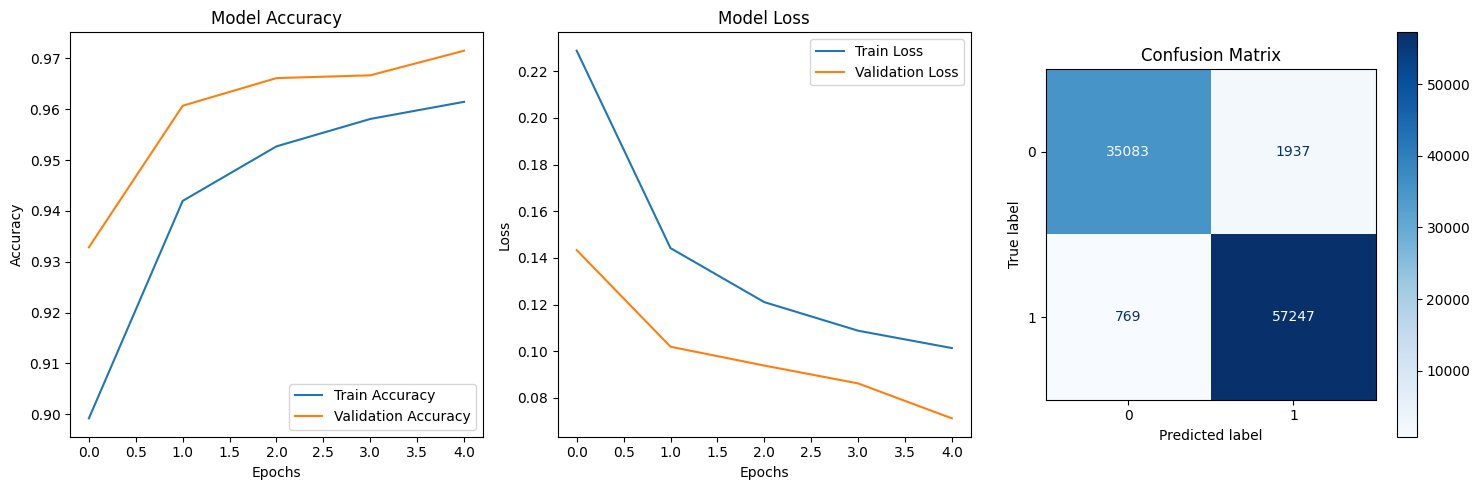

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create subplots: 1 row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training & validation loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax[2], cmap="Blues")
ax[2].set_title('Confusion Matrix')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

### **Label: Dominance**

In [ ]:
print(main_df['dominance'])

0         4.76
1         3.32
2         4.28
3         7.56
4         4.76
          ... 
475173    9.16
475174    3.96
475175    9.16
475176    3.96
475177    9.16
Name: dominance, Length: 475178, dtype: float64


In [ ]:
# Thresholding the 'arousal' column
main_df['dominance_bin'] = (main_df['dominance'] >= 4.5).astype(int)

In [ ]:
Counter(main_df['dominance_bin'])

Counter({1: 215534, 0: 259644})

In [ ]:
main_df.iloc[:, 5:-16].head()

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,-0.385125,0.134773,-0.912970,-0.492953,0.132330,-0.859934,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.274001,0.025506,-0.961391,0.141810,0.033585,-0.989324,0.210,0.030,434.0,435.2,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.756852,0.231358,-0.611268,0.664592,0.245878,-0.705593,0.824,0.348,156.8,158.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.143009,0.317884,-0.937282,-0.285699,0.318995,-0.903669,-0.229,0.333,753.6,754.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.384993,0.134877,-0.913010,-0.492941,0.132440,-0.859923,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [ ]:
# Features (all columns except the last 13)
X = main_df.iloc[:, 5:-16].values

In [ ]:
# Labels (binary column 'arousal_bin')
y = main_df['dominance_bin'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 0.401387,  0.339054, -0.850841, ...,  0.      ,  1.      ,
         0.      ],
       [ 0.507299,  0.117087, -0.853779, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.450131, -0.034265, -0.892305, ...,  0.      ,  1.      ,
         1.      ],
       ...,
       [ 0.740757,  0.187753, -0.645002, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.427458,  0.095352, -0.898993, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.278451,  0.043809, -0.959451, ...,  0.      ,  0.      ,
         0.      ]])

In [ ]:
y_train

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
Counter(y_train)

Counter({0: 207498, 1: 172644})

In [ ]:
# Normalize features for better training (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train

array([[ 1.12430756,  0.96054097,  0.78635026, ..., -0.42433416,
         0.98320006, -0.93910049],
       [ 1.48183003, -0.29584174,  0.75027026, ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 1.28885053, -1.15252781,  0.2771531 , ..., -0.42433416,
         0.98320006,  1.06484877],
       ...,
       [ 2.26990389,  0.10414358,  3.3141487 , ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 1.21231429, -0.41886669,  0.19502136, ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 0.70931793, -0.71061156, -0.54743094, ..., -0.42433416,
        -1.017087  , -0.93910049]])

In [ ]:
X_train.shape

(380142, 709)

In [ ]:
# Define the model
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),  # Dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,  # Adjust epochs based on performance
    batch_size=32,  # Adjust batch size based on data size
    verbose=1
)

Epoch 1/5
11880/11880 [==============================] - 50s 4ms/step - loss: 0.1696 - accuracy: 0.9320 - val_loss: 0.1020 - val_accuracy: 0.9597
Epoch 2/5
11880/11880 [==============================] - 50s 4ms/step - loss: 0.1043 - accuracy: 0.9602 - val_loss: 0.0962 - val_accuracy: 0.9666
Epoch 3/5
11880/11880 [==============================] - 49s 4ms/step - loss: 0.0882 - accuracy: 0.9665 - val_loss: 0.0608 - val_accuracy: 0.9748
Epoch 4/5
11880/11880 [==============================] - 49s 4ms/step - loss: 0.0801 - accuracy: 0.9702 - val_loss: 0.0638 - val_accuracy: 0.9735
Epoch 5/5
11880/11880 [==============================] - 49s 4ms/step - loss: 0.0737 - accuracy: 0.9732 - val_loss: 0.0555 - val_accuracy: 0.9776


In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 97.76%


2970/2970 [==============================] - 5s 2ms/step


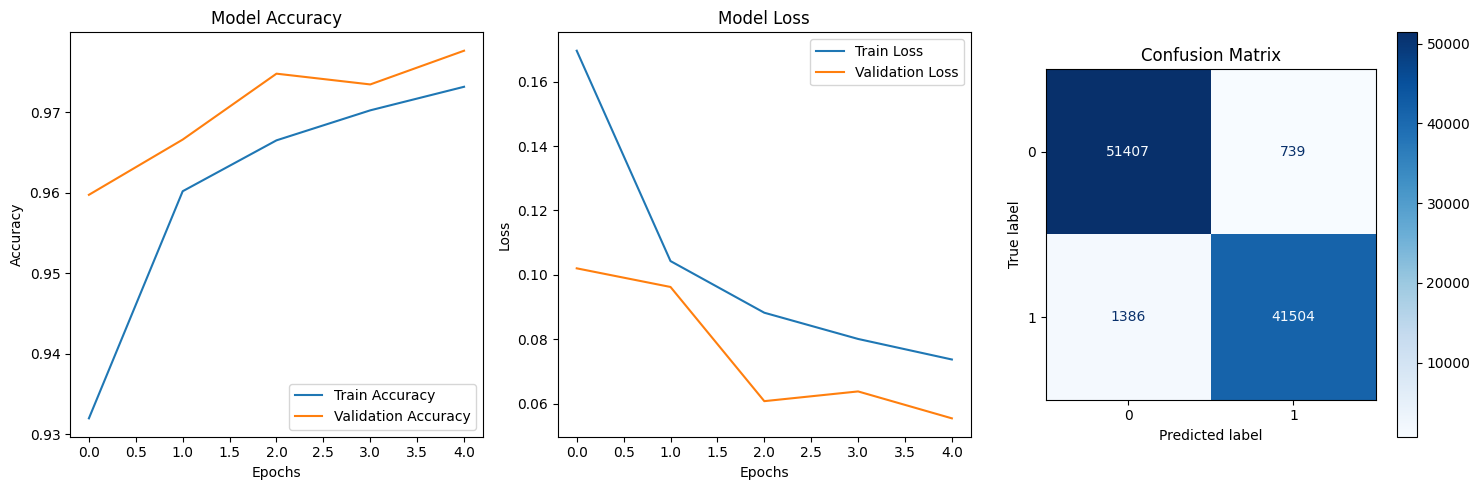

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create subplots: 1 row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training & validation loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax[2], cmap="Blues")
ax[2].set_title('Confusion Matrix')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

### **Label: Liking**

In [ ]:
print(main_df['liking'])

0         8.12
1         7.80
2         5.64
3         7.88
4         8.12
          ... 
475173    9.16
475174    8.44
475175    9.16
475176    8.44
475177    9.16
Name: liking, Length: 475178, dtype: float64


In [ ]:
# Thresholding the 'arousal' column
main_df['liking_bin'] = (main_df['liking'] >= 4.5).astype(int)

In [ ]:
Counter(main_df['liking_bin'])

Counter({1: 400534, 0: 74644})

In [ ]:
main_df.iloc[:, 5:-17]

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,-0.385125,0.134773,-0.912970,-0.492953,0.132330,-0.859934,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.274001,0.025506,-0.961391,0.141810,0.033585,-0.989324,0.210,0.030,434.0,435.2,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.756852,0.231358,-0.611268,0.664592,0.245878,-0.705593,0.824,0.348,156.8,158.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.143009,0.317884,-0.937282,-0.285699,0.318995,-0.903669,-0.229,0.333,753.6,754.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.384993,0.134877,-0.913010,-0.492941,0.132440,-0.859923,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475173,-0.110487,0.521078,-0.846328,-0.257413,0.516145,-0.816905,-0.218,0.558,723.6,724.6,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
475174,-0.433888,0.591868,-0.679289,-0.562977,0.533961,-0.630827,-0.650,0.710,979.7,981.3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
475175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,721.9,722.9,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
475176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,980.3,981.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
# Features (all columns except the last 13)
X = main_df.iloc[:, 5:-17].values

In [ ]:
# Labels (binary column 'arousal_bin')
y = main_df['liking_bin'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 0.401387,  0.339054, -0.850841, ...,  0.      ,  1.      ,
         0.      ],
       [ 0.507299,  0.117087, -0.853779, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.450131, -0.034265, -0.892305, ...,  0.      ,  1.      ,
         1.      ],
       ...,
       [ 0.740757,  0.187753, -0.645002, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.427458,  0.095352, -0.898993, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.278451,  0.043809, -0.959451, ...,  0.      ,  0.      ,
         0.      ]])

In [ ]:
y_train

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
Counter(y_train)

Counter({0: 59814, 1: 320328})

In [ ]:
# Normalize features for better training (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train

array([[ 1.12430756,  0.96054097,  0.78635026, ..., -0.42433416,
         0.98320006, -0.93910049],
       [ 1.48183003, -0.29584174,  0.75027026, ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 1.28885053, -1.15252781,  0.2771531 , ..., -0.42433416,
         0.98320006,  1.06484877],
       ...,
       [ 2.26990389,  0.10414358,  3.3141487 , ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 1.21231429, -0.41886669,  0.19502136, ..., -0.42433416,
        -1.017087  , -0.93910049],
       [ 0.70931793, -0.71061156, -0.54743094, ..., -0.42433416,
        -1.017087  , -0.93910049]])

In [ ]:
X_train.shape

(380142, 709)

In [ ]:
# Define the model
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),  # Dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    # Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,  # Adjust epochs based on performance
    batch_size=32,  # Adjust batch size based on data size
    verbose=1
)

Epoch 1/5
11880/11880 [==============================] - 39s 3ms/step - loss: 0.0741 - accuracy: 0.9730 - val_loss: 0.0313 - val_accuracy: 0.9902
Epoch 2/5
11880/11880 [==============================] - 35s 3ms/step - loss: 0.0409 - accuracy: 0.9864 - val_loss: 0.0261 - val_accuracy: 0.9906
Epoch 3/5
11880/11880 [==============================] - 36s 3ms/step - loss: 0.0318 - accuracy: 0.9891 - val_loss: 0.0255 - val_accuracy: 0.9918
Epoch 4/5
11880/11880 [==============================] - 36s 3ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.0172 - val_accuracy: 0.9937
Epoch 5/5
11880/11880 [==============================] - 36s 3ms/step - loss: 0.0257 - accuracy: 0.9910 - val_loss: 0.0157 - val_accuracy: 0.9933


In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 99.33%


2970/2970 [==============================] - 5s 2ms/step


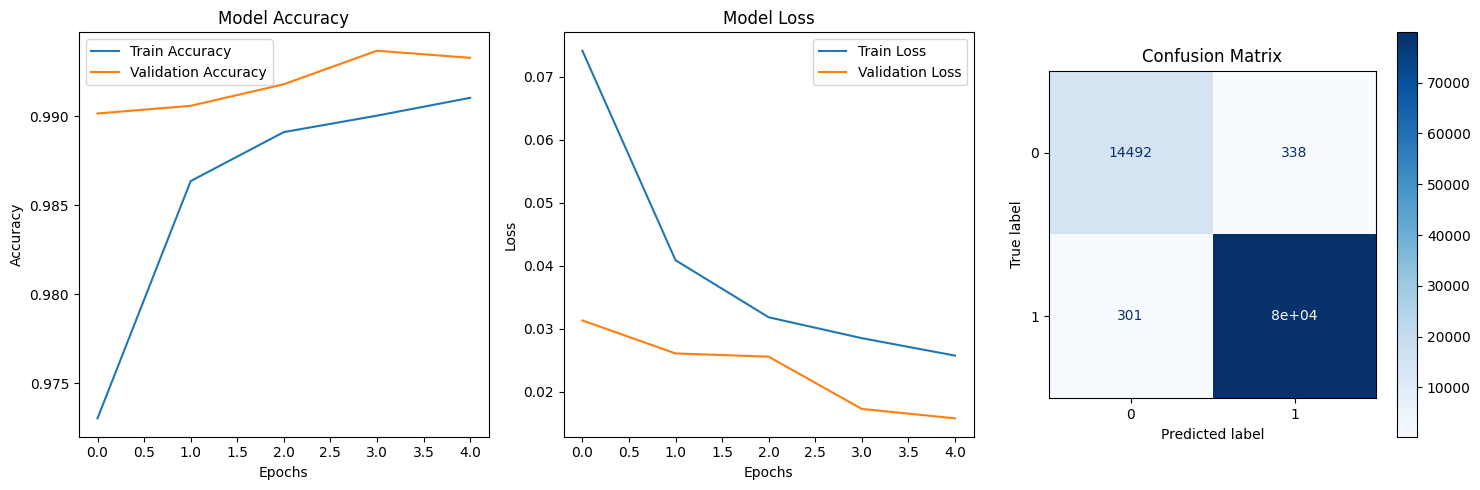

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create subplots: 1 row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training & validation loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax[2], cmap="Blues")
ax[2].set_title('Confusion Matrix')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()